In [13]:
import ast
import numpy as np
import pandas as pd
from area import area
from sklearn.model_selection import train_test_split, cross_validate
from sklearn.metrics import classification_report
from lightgbm import LGBMClassifier
import shap as shap

%matplotlib inline

In [14]:
SEED = 797
CV = 5

pd.set_option('display.max_rows', 100)
pd.set_option('display.max_columns', 100)

In [1]:
import mlflow

# S3 Object Storage of Yandex Cloud
%env AWS_REGION = <>
%env AWS_ACCESS_KEY_ID = <>
%env AWS_SECRET_ACCESS_KEY = <>

# MLflow
%env MLFLOW_SERVER_HOST = <>
%env MLFLOW_SERVER_PORT = <>


mlflow.set_tracking_uri(
    f"http://{os.environ['MLFLOW_SERVER_HOST']}:{os.environ['MLFLOW_SERVER_PORT']}"
)
print(f"tracking MLflow URI: '{mlflow.get_tracking_uri()}'")
print(f"{mlflow.list_experiments()}")
mlflow.set_experiment("agroculture-classification-innopolis")

env: AWS_REGION=<>
env: AWS_ACCESS_KEY_ID=<>
env: AWS_SECRET_ACCESS_KEY=<>
env: MLFLOW_SERVER_HOST=<>
env: MLFLOW_SERVER_PORT=<>


In [16]:
df_train = pd.read_csv("train_dataset_train.csv")
df_test = pd.read_csv('test_dataset_test.csv')
solution = pd.read_csv('sample_solution.csv')

In [17]:
def add_features(data: pd.DataFrame) -> pd.DataFrame:
    df = data.copy()
    df['.geo_lat'] = df['.geo'].apply(lambda x: 
                                        ( 
                                            ast.literal_eval(x)['coordinates'][0][0][0][0] 
                                            if isinstance(ast.literal_eval(x)['coordinates'][0][0][0], list) 
                                            else ast.literal_eval(x)['coordinates'][0][0][0]
                                        )
                                        if ast.literal_eval(x).get('coordinates')
                                        else ast.literal_eval(x)['geometries'][0]['coordinates'][0][0]
                                    )
    df['.geo_lon'] = df['.geo'].apply(lambda x: 
                                        (
                                            ast.literal_eval(x)['coordinates'][0][0][0][1] 
                                            if isinstance(ast.literal_eval(x)['coordinates'][0][0][1], list) 
                                            else ast.literal_eval(x)['coordinates'][0][0][1]
                                        )
                                        if ast.literal_eval(x).get('coordinates')
                                        else ast.literal_eval(x)['geometries'][0]['coordinates'][0][1]
                                    )
    df['.geo_area'] = df['.geo'].apply(lambda x: area(ast.literal_eval(x))) / 10000
    df['.geo_zone'] = 0
    df.loc[(df['.geo_lat'] < 35.5) & (df['.geo_lon'] < 54), '.geo_zone'] = 1
    df.loc[(df['.geo_lat'] > 35.5) & (df['.geo_lat'] < 38) & (df['.geo_lon'] < 54), '.geo_zone'] = 2
    df.loc[(df['.geo_lat'] > 38) & (df['.geo_lat'] < 44) & (df['.geo_lon'] < 52.5), '.geo_zone'] = 3
    df.loc[(df['.geo_lat'] > 43) & (df['.geo_lat'] < 47) & (df['.geo_lon'] > 54), '.geo_zone'] = 4
    df.loc[(df['.geo_lat'] > 47), '.geo_zone'] = 5
    return df

In [18]:
NUM_FEATURES = [
       '.geo_area', #'area',
       'nd_mean_2021-04-16', 'nd_mean_2021-04-19',
       'nd_mean_2021-04-22', 'nd_mean_2021-04-26', 'nd_mean_2021-04-28',
       'nd_mean_2021-05-02', 'nd_mean_2021-05-04', 'nd_mean_2021-05-07',
       'nd_mean_2021-05-16', 'nd_mean_2021-05-17', 'nd_mean_2021-05-21',
       'nd_mean_2021-05-26', 'nd_mean_2021-05-27', 'nd_mean_2021-05-29',
       'nd_mean_2021-06-06', 'nd_mean_2021-06-09', 'nd_mean_2021-06-13',
       'nd_mean_2021-06-16', 'nd_mean_2021-06-18', 'nd_mean_2021-06-19',
       'nd_mean_2021-06-20', 'nd_mean_2021-06-22', 'nd_mean_2021-06-25',
       'nd_mean_2021-06-27', 'nd_mean_2021-07-07', 'nd_mean_2021-07-08',
       'nd_mean_2021-07-09', 'nd_mean_2021-07-13', 'nd_mean_2021-07-15',
       'nd_mean_2021-07-17', 'nd_mean_2021-07-20', 'nd_mean_2021-07-26',
       'nd_mean_2021-07-27', 'nd_mean_2021-07-29', 'nd_mean_2021-07-31',
       'nd_mean_2021-08-07', 'nd_mean_2021-08-12',
       'nd_mean_2021-04-15', 'nd_mean_2021-04-18', 'nd_mean_2021-04-25',
       'nd_mean_2021-04-27', 'nd_mean_2021-04-29', 'nd_mean_2021-04-30',
       'nd_mean_2021-06-07', 'nd_mean_2021-06-12', 'nd_mean_2021-06-28',
       'nd_mean_2021-08-01', 'nd_mean_2021-08-11', 'nd_mean_2021-05-01',
       'nd_mean_2021-05-03', 'nd_mean_2021-05-10', 'nd_mean_2021-05-15',
       'nd_mean_2021-06-02', 'nd_mean_2021-06-03', 'nd_mean_2021-07-04',
       'nd_mean_2021-08-10', 'nd_mean_2021-08-23', 'nd_mean_2021-04-20',
       'nd_mean_2021-04-23', 'nd_mean_2021-05-09', 'nd_mean_2021-05-19',
       'nd_mean_2021-05-20', 'nd_mean_2021-06-04', 'nd_mean_2021-06-05',
       'nd_mean_2021-06-10', 'nd_mean_2021-07-05', 'nd_mean_2021-08-13',
       'nd_mean_2021-08-27', 'nd_mean_2021-05-08', 'nd_mean_2021-05-24',
       '.geo_lat', '.geo_lon', '.geo_zone',
]
ALL_FEATURES = NUM_FEATURES
TARGET = 'crop'

In [19]:
X_train = add_features(data=df_train)[ALL_FEATURES]
y_train = df_train[TARGET]

X_test = add_features(data=df_test)[ALL_FEATURES]

## Model CV

In [20]:
def cv_model(model, X, y, cv=CV, model_name='None', params=None, submit='no'):
    with mlflow.start_run():
        result = cross_validate(model, X, y, cv=cv,
                        scoring=('recall_macro', 'recall_micro', 'f1_macro'),
                        return_train_score=True)
        print(f"CV time: {sum(result['fit_time']) + sum(result['score_time'])}")
        mlflow.set_tag("model", model_name)
        mlflow.set_tag("cv", "yes")
        mlflow.set_tag("submit", submit)
        mlflow.log_param("model", model_name)
        if params:
            mlflow.log_params(params)
        mlflow.log_metric("recall_macro_mean_test", np.mean(result['test_recall_macro']))
        mlflow.log_metric("recall_macro_std_test", np.std(result['test_recall_macro']))
        mlflow.log_metric("recall_micro_mean_test", np.mean(result['test_recall_micro']))
        mlflow.log_metric("recall_micro_std_test", np.std(result['test_recall_micro']))
        mlflow.log_metric("f1_mean_test", np.mean(result['test_f1_macro']))
        mlflow.log_metric("f1_std_test", np.std(result['test_f1_macro']))
        mlflow.log_metric("recall_macro_mean_train", np.mean(result['train_recall_macro']))
        mlflow.log_metric("recall_macro_std_train", np.std(result['train_recall_macro']))
        mlflow.log_metric("recall_micro_mean_train", np.mean(result['train_recall_micro']))
        mlflow.log_metric("recall_micro_std_train", np.std(result['train_recall_micro']))
        mlflow.log_metric("f1_mean_train", np.mean(result['train_f1_macro']))
        mlflow.log_metric("f1_std_train", np.std(result['train_f1_macro']))
        for i in range(CV):
            mlflow.log_metric(f"recall_macro_{i}_test", result['test_recall_macro'][i])
            mlflow.log_metric(f"recall_micro_{i}_test", result['test_recall_macro'][i])
            mlflow.log_metric(f"f1_{i}_test", result['test_recall_macro'][i])

### LightGBM

In [21]:
submit = 'submit_41_1_lgbm'

clf = LGBMClassifier()

cv_model(clf, X=X_train, y=y_train, model_name="lgbm", submit=submit)

CV time: 6.343999624252319


In [22]:
clf = LGBMClassifier()
clf.fit(X_train, y_train)

predictions = clf.predict(X_test)
solution.crop = predictions
solution.to_csv(f"{submit}.csv", index=False)

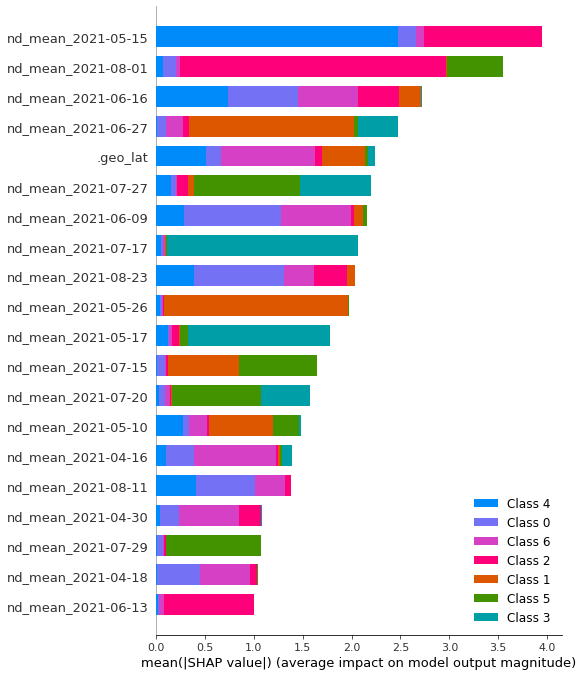

In [23]:
explainer = shap.TreeExplainer(clf)
shap_values = explainer.shap_values(X_train)
shap.summary_plot(shap_values, X_train, feature_names=ALL_FEATURES)

In [24]:
feature_importance_df = pd.DataFrame(clf.feature_importances_, index=ALL_FEATURES)
feature_importance_df.sort_values(by=0, ascending=False)

,0
.geo_lat,903
nd_mean_2021-06-16,858
.geo_lon,733
nd_mean_2021-04-16,654
nd_mean_2021-07-27,590
nd_mean_2021-05-10,583
nd_mean_2021-08-23,523
nd_mean_2021-06-09,484
nd_mean_2021-05-15,472
nd_mean_2021-06-27,457
